In [59]:
! pip install scikit-surprise

     |████████████████████████████████| 11.8MB 31.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617631 sha256=20c144bcf95a5fb9068be9799b060655756f5d856186ad9bede49c608651131c
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [60]:
import surprise as sp
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader


from collections import defaultdict
from operator import itemgetter
import heapq

import os
import csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df1 = pd.read_csv('/content/drive/Shareddrives/mayur/Music recommender system/kaggle/kaggle_visible_evaluation_triplets.txt',sep='\t',names=['user_id','song_id','freq'])

In [4]:
df1.head()

,user_id,song_id,freq
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


In [5]:
df1.describe(include='all')

,user_id,song_id,freq
count,1450933,1450933,1.450933e+06
unique,110000,163206,NaN
top,7d90be8dfdbde170f036ce8a4b915440137cb11c,SOFRQTD12A81C233C0,NaN
freq,53,5043,NaN
mean,NaN,NaN,3.187149e+00
std,NaN,NaN,7.051664e+00
min,NaN,NaN,1.000000e+00
25%,NaN,NaN,1.000000e+00
50%,NaN,NaN,1.000000e+00
75%,NaN,NaN,3.000000e+00


In [6]:
unique_tracks = pd.read_csv('/content/drive/Shareddrives/mayur/Music recommender system/kaggle/unique_tracks.txt',sep='<SEP>',names=['track_id','song_id','artist_id','release'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [7]:
unique_tracks.head()

,track_id,song_id,artist_id,release
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [8]:
unique_tracks.describe(include='all')

,track_id,song_id,artist_id,release
count,1000000,1000000,1000000,999985
unique,1000000,999056,72665,702000
top,TRYEZNE128F425AB86,SONBEKD12AB01894DC,Michael Jackson,Intro
freq,1,3,194,1511


In [9]:
df1.isnull().sum()

user_id    0
song_id    0
freq       0
dtype: int64

In [10]:
unique_tracks.isnull().sum()

track_id      0
song_id       0
artist_id     0
release      15
dtype: int64

In [11]:
unique_tracks['release'] = unique_tracks['release'].fillna(unique_tracks['release'].mode()[0])

In [12]:
unique_tracks['song_id'].duplicated().sum()

944

In [13]:
#unique_tracks['song_id'] = unique_tracks.drop_duplicates(subset='song_id')

In [14]:
#unique_tracks.isnull().sum()

In [15]:
#unique_tracks['song_id'] = unique_tracks['song_id'].replace(np.nan,'Others',inplace=True)
#unique_tracks.head()

In [16]:
df1.head()

,user_id,song_id,freq
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


In [17]:
combined = df1.merge(unique_tracks,on='song_id')

In [18]:
combined.head()

,user_id,song_id,freq,track_id,artist_id,release
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,c34670d9c1718361feb93068a853cead3c95b76a,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,SOBONKR12A58A7A7E0,2,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,SOBONKR12A58A7A7E0,4,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One


In [19]:
combined.shape

(1491952, 6)

In [20]:
combined.isnull().sum()

user_id      0
song_id      0
freq         0
track_id     0
artist_id    0
release      0
dtype: int64

In [21]:
combined['song_id'].duplicated().sum()

1328746

#### Remove duplicates value

In [22]:
combined=combined.drop_duplicates(subset=['user_id', 'song_id','freq','artist_id'])

In [23]:
combined.shape

(1451761, 6)

* there was around 40 thousand duplicates value.

In [24]:
#df3 = pd.merge(df1, unique_tracks, on=['song_id'], how='inner')

In [25]:
#df3['song_id'].duplicated().sum()

In [26]:
print("Total number of data points:",combined.shape[0])
print("Total number of users:",combined['user_id'].unique().shape[0])
print("Total number of songs:",combined['song_id'].unique().shape[0])
print("Total number of tracks:",combined['track_id'].unique().shape[0])
print("Total number of artists:",combined['artist_id'].unique().shape[0])

Total number of data points: 1451761
Total number of users: 110000
Total number of songs: 163206
Total number of tracks: 163217
Total number of artists: 28367


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


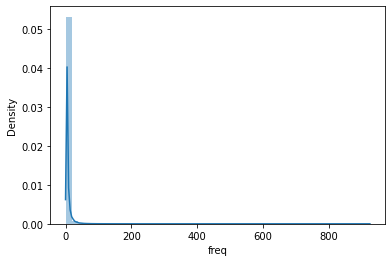

In [27]:
sns.distplot(combined['freq'])

# Number Of Songs Listened Per User

In [28]:
songs_per_user = combined.groupby('user_id')['song_id'].count()
songs_per_user

user_id
00007a02388c208ea7176479f6ae06f8224355b3     9
00014a76ed063e1a749171a253bca9d9a0ff1782    11
00015189668691680bb1a2e58afde1541ec92ced    17
0001ff7aa2667c8d8b945317b88adaed1c0b9dc2     9
00020fcd8b01986a6a85b896ccde6c49f35142ad    32
                                            ..
fffdef71f13352e9cff769f1d96f5ccf90f8955e     7
fffe29116f96c97b47a5dabdd406784ad0ba6f30     6
fffe5b73c50c72ca9c54947efac1fcacf59c4a17    23
fffed0bee753cd78494011b8b55dafd4f5c7e5ff    13
ffff07d7d9bb187aa58c7b81b3d3f35e7cf7c0ee    13
Name: song_id, Length: 110000, dtype: int64

In [29]:
songs_per_user.sort_values().head()

user_id
bb740fa620a7cb24a2f0421afa0426c3f4213fa9    5
3835e059e26d4a69f66a18edf704677915293b14    5
bf1ef0db93cab1c77ae7f1f387ae865a53c3a999    5
bf26ae07b05db631c509d52cde868624d32d138c    5
bf307b61c98ca936228e6e6bc5f2bac839cd5fb2    5
Name: song_id, dtype: int64

In [30]:
songs_per_user.describe()

count    110000.000000
mean         13.197827
std           8.075367
min           5.000000
25%           7.000000
50%          11.000000
75%          17.000000
max          53.000000
Name: song_id, dtype: float64

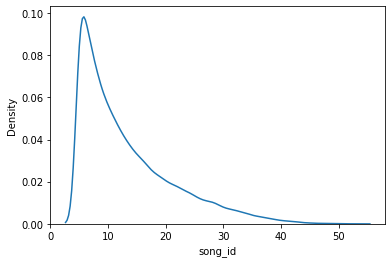

In [31]:
sns.kdeplot(songs_per_user)

* Songs per user follows right skewed distribution.

In [32]:
songs_per_user=songs_per_user.sort_values(ascending=False)
songs_per_user.head

<bound method NDFrame.head of user_id
7d90be8dfdbde170f036ce8a4b915440137cb11c    53
0f8308935bcbb9a1e04ebb7c4d41c037e5f23b90    52
016a24e91a72c159a5048ab1b9b2ba5ce761b526    52
2e424b28bff1f62a2dae22a918f09f9c30c06d1b    52
03ad93fdb01506ce205f4708decf8e4b1ae90fff    52
                                            ..
bf307b61c98ca936228e6e6bc5f2bac839cd5fb2     5
bf26ae07b05db631c509d52cde868624d32d138c     5
bf1ef0db93cab1c77ae7f1f387ae865a53c3a999     5
3835e059e26d4a69f66a18edf704677915293b14     5
bb740fa620a7cb24a2f0421afa0426c3f4213fa9     5
Name: song_id, Length: 110000, dtype: int64>

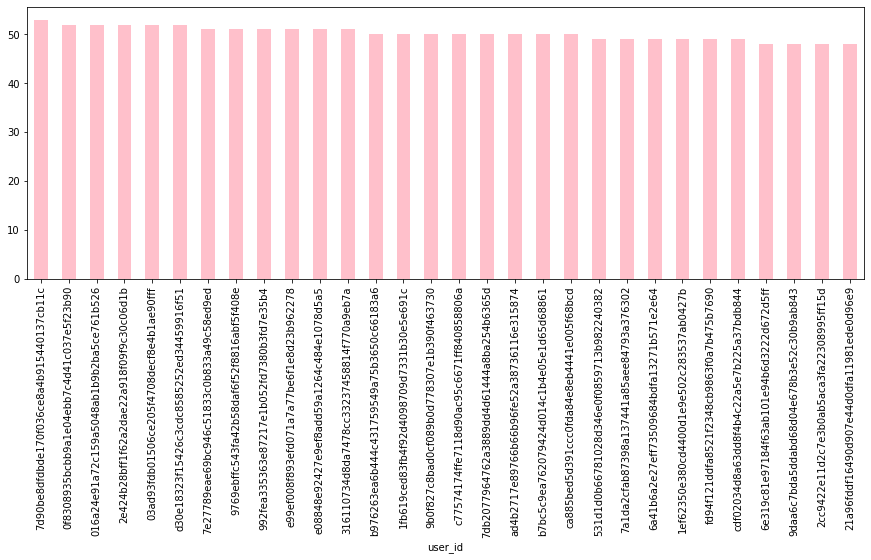

In [33]:
songs_per_user.head(30).plot(kind='bar',figsize=(15,5),color='pink')

* Highest of songs listen per user is 57.

 

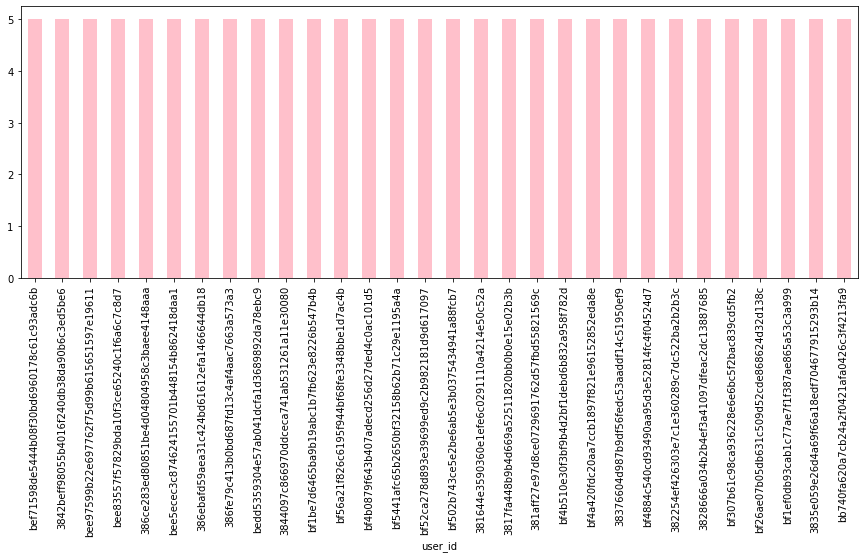

In [34]:
songs_per_user.tail(30).plot(kind='bar',figsize=(15,5),color='pink')

* Lower count of song listen per user is 5.

In [35]:
songs_per_user.median()

11.0

* median is 11 hence on average 11 songs listen by per users. 

## **Popular Artist**

In [36]:
popular_artist = combined.groupby('artist_id')['song_id'].count()
popular_artist

artist_id
!!!                     109
!Deladap                  3
& And Oceans              2
'68 Comeback             22
'N Sync/Phil Collins     48
                       ... 
Étienne Daho             45
Íon                       5
Ólafur Arnalds           78
Órla Fallon               1
Özlem Tekin               1
Name: song_id, Length: 28367, dtype: int64

In [37]:
highest_popularity_artist=popular_artist.sort_values(ascending=False).head()

In [38]:
highest_popularity_artist

artist_id
Coldplay                  12279
Kings Of Leon              8514
Florence + The Machine     8213
Justin Bieber              7669
Jack Johnson               6784
Name: song_id, dtype: int64

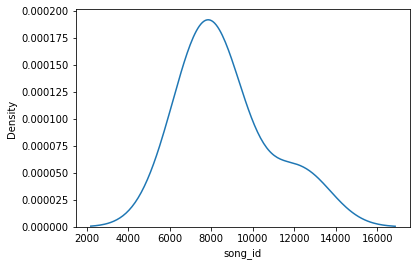

In [39]:
sns.kdeplot(highest_popularity_artist)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


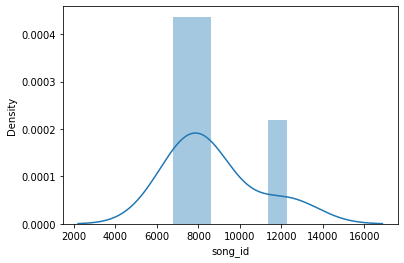

In [40]:
sns.distplot(highest_popularity_artist)

* highest_popularity_artist follows normal distribution

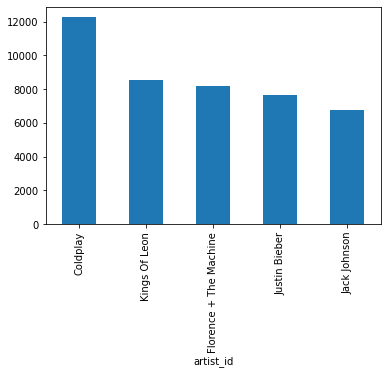

In [41]:
highest_popularity_artist.head(30).plot(kind='bar',)

* Coldplay,Kings Of Leon,Justin Bieber,
Florence + The Machine,Eminem are most popular artist

In [42]:
highest_popularity_artist.mean()

8691.8

* Average of highest popular artist is 8691.8

## Most Popular Songs

In [43]:
song_popularity = combined.groupby('song_id')['freq'].count()
song_popularity

song_id
SOAAAFI12A6D4F9C66     2
SOAAAGK12AB0189572     1
SOAAAGQ12A8C1420C8    33
SOAAAMT12AB018C9C4     1
SOAAAQN12AB01856D3     2
                      ..
SOZZZHM12A8C140DEF     8
SOZZZKJ12A6D4FBF66     1
SOZZZPV12A8C1444B5    45
SOZZZRV12A8C1361F1     1
SOZZZWN12AF72A1E29     2
Name: freq, Length: 163206, dtype: int64

In [44]:
highest_song_popularity=song_popularity.sort_values(ascending=False).head()
highest_song_popularity

song_id
SOFRQTD12A81C233C0    5043
SOAUWYT12A81C206F1    4483
SOBONKR12A58A7A7E0    4136
SOAXGDH12A8C13F8A1    3780
SOSXLTC12AF72A7F54    3672
Name: freq, dtype: int64

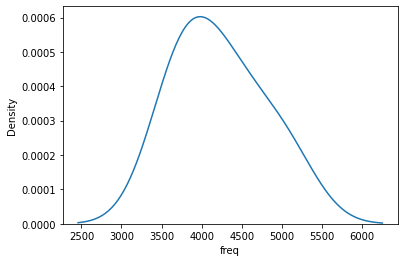

In [45]:
sns.kdeplot(highest_song_popularity)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


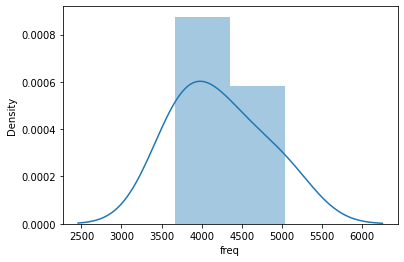

In [46]:
sns.distplot(highest_song_popularity)

* highest_song_popularity follows normal distribution.


In [47]:
highest_song_popularity.mean()

4222.8

* On an average users listen 4222.8 popular songs.

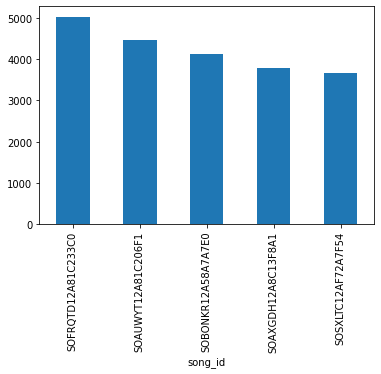

In [48]:
highest_song_popularity.head(15).plot(kind='bar')

## Most played Song

In [49]:
most_frequent_song = combined.groupby('release')['freq'].count()
most_frequent_song

release

Ef Ég Hefði Aldrei...                                        1

Light Mass Prayers                                           4

The Arsonist Story":  Evil Craves Attention/Our Son/10x10    1

Ég Átti Gráa Æsku                                            4
 (Jack The Stripper)                                          2
                                                             ..
Þú ert jörðin                                                 2
Þú ert sólin                                                  2
ça Me Fait Du Bien                                            2
étienne d'août                                                4
þetta Gerist á Bestu Bæjum                                    1
Name: freq, Length: 137624, dtype: int64

In [50]:
most_played_song = most_frequent_song.sort_values(ascending=False).head()
most_played_song

release
Sehr kosmisch                     5043
Undo                              4483
You're The One                    4270
Dog Days Are Over (Radio Edit)    3780
Revelry                           3672
Name: freq, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


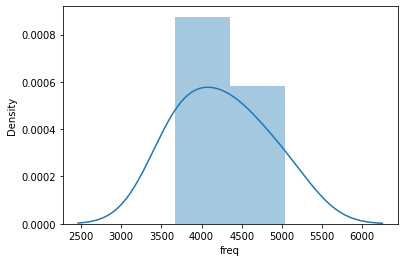

In [51]:
sns.distplot(most_played_song)

* most_played_song follows normal distribution.

In [52]:
most_played_song.mean()

4249.6

* On an average users used to listen song 4279 times.

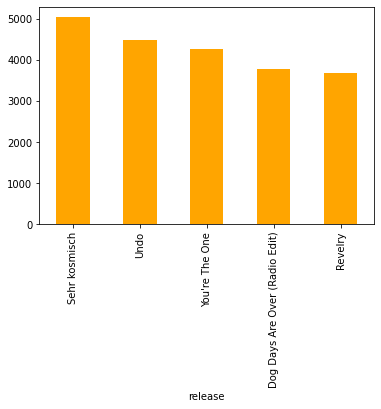

In [53]:
most_played_song.plot(kind='bar',color='orange')

* Sehr kosmisch ,Undo,You're The One ,Use Somebody,Dog Days Are Over are most popular songs.                        

## Most Played Artist

In [54]:
artist = combined.groupby('artist_id')['freq'].count()
artist

artist_id
!!!                     109
!Deladap                  3
& And Oceans              2
'68 Comeback             22
'N Sync/Phil Collins     48
                       ... 
Étienne Daho             45
Íon                       5
Ólafur Arnalds           78
Órla Fallon               1
Özlem Tekin               1
Name: freq, Length: 28367, dtype: int64

In [55]:
most_played_artist = artist.sort_values(ascending=False).head()
most_played_artist

artist_id
Coldplay                  12279
Kings Of Leon              8514
Florence + The Machine     8213
Justin Bieber              7669
Jack Johnson               6784
Name: freq, dtype: int64

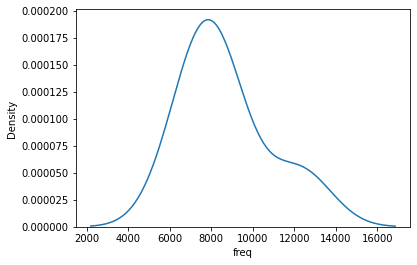

In [56]:
sns.kdeplot(most_played_artist)

* most_played_artist follow normal distribution

In [57]:
most_played_artist.mean()

8691.8

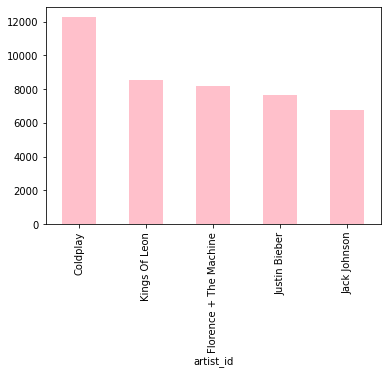

In [58]:
most_played_artist.head(15).plot(kind='bar',color='pink')

* Coldplay,Kings Of Leon,Justin Bieber,
Florence + The Machine,Eminem are most played artist

# Model Building

## Collaborative Filtering 
<h1>Nearest Neighborhood </h1>

<h2>Item Base Recommender System</h2>

In [61]:
music_freq_count=(combined.groupby(by=['song_id'])['freq'].count().
                 reset_index().rename(columns={'freq':'TotalFreqCount'})
                 [['song_id','TotalFreqCount']])
music_freq_count.head()

,song_id,TotalFreqCount
0,SOAAAFI12A6D4F9C66,2
1,SOAAAGK12AB0189572,1
2,SOAAAGQ12A8C1420C8,33
3,SOAAAMT12AB018C9C4,1
4,SOAAAQN12AB01856D3,2


In [62]:
music_freq_count.shape

(163206, 2)

In [63]:
data=combined.merge(music_freq_count,on='song_id')

In [64]:
data=data[['user_id','song_id','TotalFreqCount']]
data.head()

,user_id,song_id,TotalFreqCount
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,4136
1,c34670d9c1718361feb93068a853cead3c95b76a,SOBONKR12A58A7A7E0,4136
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,SOBONKR12A58A7A7E0,4136
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,SOBONKR12A58A7A7E0,4136
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,SOBONKR12A58A7A7E0,4136


In [65]:
data.shape

(1451761, 3)

In [66]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
col=['user_id','song_id']

for i in col:
  data[i]=le.fit_transform(data[i])

data.head()

,user_id,song_id,TotalFreqCount
0,108811,10546,4136
1,83893,10546,4136
2,84614,10546,4136
3,98036,10546,4136
4,80305,10546,4136


In [67]:
dataset=data.head(10000)

##### Build model by surprise library

In [68]:
from surprise import Reader, Dataset
reader = Reader()
data = Dataset.load_from_df(dataset[['user_id','song_id','TotalFreqCount']], reader)

In [69]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.25)

In [70]:
from surprise import KNNBaseline, accuracy
algo = KNNBaseline(k=20, sim_options={'name': 'cosine', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [71]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [72]:
from surprise import accuracy
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 3460.2965
MAE:  3460.2965


3460.2965333333336

#### Top 10 Songs recoomendation for each user

In [79]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [80]:
top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Streaming output truncated to the last 5000 lines.
74372 [28684, 36622]
108811 [10546, 36622]
81255 [28684, 36622]
10582 [28684, 10546]
24848 [28684, 10546]
57366 [28684, 36622]
47138 [28684, 10546]
41857 [10546, 36622]
17885 [28684, 10546]
46860 [28684, 36622]
81895 [10546, 36622]
24683 [28684, 10546]
80947 [28684, 36622]
242 [28684, 36622]
22763 [36622]
104208 [28684]
42847 [10546, 36622]
29942 [28684, 36622]
88101 [10546, 36622]
92320 [10546, 36622]
78851 [28684, 36622]
96734 [10546, 36622]
1517 [28684, 36622]
108557 [28684, 36622]
32981 [28684, 10546]
48476 [28684, 36622]
104128 [28684, 10546]
86851 [28684, 36622]
63834 [28684, 36622]
32846 [28684, 10546]
70135 [28684, 36622]
95756 [10546, 36622]
54207 [10546, 36622]
42825 [28684, 36622]
92735 [28684, 36622]
26024 [10546, 36622]
54256 [10546, 36622]
45228 [28684, 36622]
70084 [28684, 10546]
16572 [28684, 10546]
30948 [10546, 36622]
82577 [28684, 10546]
108988 [28684, 36622]
108942 [28684, 36622]
90037 [28684, 36622]
108329 [10546, 